## Real World Application: Protein Non-Redundancy
This notebook applies the teachings from this week's project to solve a real world example: finding the least redundant set of protein sequences from real data! 

We use sample data found from [this website](http://ekhidna.biocenter.helsinki.fi/dali/) - namely, we use [this file](http://ekhidna.biocenter.helsinki.fi/daliviewer/matrix_EXAMPLE/ordered) which was also copied [locally](./protein_similarities.csv).

Setting up environment
1. Get anaconda
2. In the command line create the environment:
    1. `conda create -n protein-redundancy python=3.6`
    2. `conda install --name protein-redundancy ipykernel -y`
    3. `conda install --name protein-redundancy pandas`
    4. `conda install --name protein-redundancy -c conda-forge matplotlib`
    5. `conda install --name protein-redundancy -c anaconda networkx`
    <br/>
3. Additional (optional) steps to instal dwave:
    1. create account at https://cloud.dwavesys.com/
    2. `conda activate protein-redundancy`
    3. `pip install dwave-ocean-sdk`
    4. Get the api key and add it to a configuration file by following the prompts from: 
        `dwave config create`
    5. `dwave install inspector`
3. Point this notebook to use the `protein-redundancy` environment you just created



In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from abstract_udmis import AbstractUDMIS
from matplotlib import pyplot as plt

First we generate a matrix of similarity values for each protein. We use sample data found from [this website](http://ekhidna.biocenter.helsinki.fi/dali/) - namely, we use [this file](http://ekhidna.biocenter.helsinki.fi/daliviewer/matrix_EXAMPLE/ordered) which was also copied [locally](./protein_similarities.csv).

In [3]:
filename = 'protein_similarities.csv'
similarity_matrix_pd = pd.read_csv(filename, header=None)
proteins = np.array(similarity_matrix_pd.pop(0))  # Array of proteins
similarity_matrix = np.array(similarity_matrix_pd)  # Matrix of "simularities" between all proteins 
print(f'Proteins: ', proteins)


Proteins:  ['1bksA' '3f2bA' '2yb1A' '3e38A' '2anuA' '3qy6A' '1v77A' '3dcpA' '3au2A'
 '1m65A' '2a3lA' '2qpxA' '3iacA' '1j5sA' '1itqA' '4mupB' '4dlfA' '2ffiA'
 '3irsA' '3cjpA' '4dziC' '2gwgA' '4ofcA' '4hk5D' '4qrnA' '2dvtA' '3gg7A'
 '2y1hB' '2vc5A' '2ob3A' '3k2gB' '1bf6A' '1a4mA' '2ogjA' '1a5kC' '1yrrB'
 '3nqbA' '2vunA' '1onxA' '3pnuA' '3giqA' '3griA' '3e74A' '4b3zD' '1gkpA'
 '2imrA' '3ooqA' '3icjA' '2oofA' '4c5yA' '3mtwA' '3mkvA' '4cqbA' '1k6wA'
 '4rdvB' '2uz9A' '2pajA' '3ls9A' '1j6pA']


Now we need to build the analogous "edge" matrix: a matrix of booleans (true = indicating high similarity between other proteins, false = indicating low similarity).

<!-- To do so, we will just take the mean scores as a threshold: anything above = highly similar (AKA an edge), anything below is not as similar. -->
We take an arbitrary threshold and plot it in the histogram of similarities. Anything above the threshold is highly similar (AKA an edge), anything below is not as similar

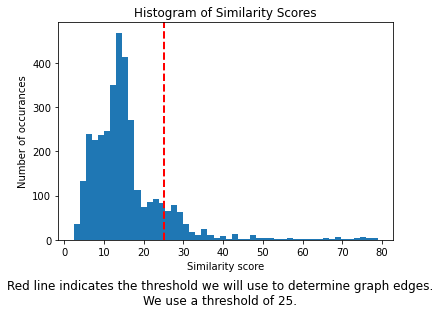

In [4]:
# threshold = np.mean(similarity_matrix)
threshold = 25

# Show a histogram indicating our threshold:
flat_similarity_matrix = np.reshape(similarity_matrix, np.size(similarity_matrix))
plt.hist(flat_similarity_matrix, 50)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram of Similarity Scores')
plt.xlabel('Similarity score')
plt.ylabel('Number of occurances')
plt.figtext(0.5, -0.09, f'Red line indicates the threshold we will use to determine graph edges.\nWe use a threshold of {threshold}.', wrap=True, horizontalalignment='center', fontsize=12)

# Defines the edge matrix:
edges = similarity_matrix > threshold
# Edges should have all false in the diagonal
np.fill_diagonal(edges, False)

Lets take a look at the graph we have

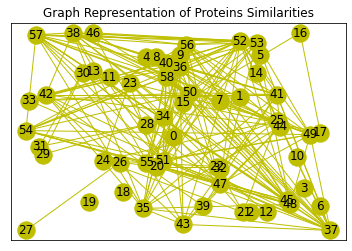

In [5]:
def generate_node_graph(title=None, occupations=None):

    if title is None:
        title = 'Graph Representation of Proteins Similarities'

    np.random.seed(0)

    fig, ax = plt.subplots()

    n_nodes = len(proteins)
    G = nx.Graph()

    for i in range(n_nodes):
        # G.add_node(i, pos=(graph[i][0], graph[i][1]))
        G.add_node(i, pos=(np.random.randint(100), np.random.randint(100)))  # Generate random positions

    edge_list = []
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if edges[i, j] == True:
                G.add_edge(i, j)
                edge_list.append([i, j])


    pos = nx.get_node_attributes(G, 'pos')

    nx.draw_networkx_nodes(G,pos, ax=ax, node_color='y' if occupations is None else ['g' if occ else 'y' for occ in occupations])
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='y')

    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.title(title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plt.show()

generate_node_graph()

Now we can try and solve this classically with a modified approach to the [example code](./Task1.ipynb).
<br/><br/>
The only differences:
- Edge matrix is passed in to the initializer
- No need to store a graph in state

In [7]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, edges):
        super().__init__()
        self.u, self.edges = u, edges
        self.num_vertices = len(self.edges)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices) 

Now lets solve the problem!

In [8]:
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01
u = 1.35

T = T_i * ((T_f/T_i) ** (t/N))

udmis = UDMIS(u, edges)

# Keep track of energy and solutions (this might take up some memory)
energy_history = np.zeros(N)
solution_history = np.zeros([N, udmis.num_vertices])

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)

    energy_history[t] = E
    solution_history[t] = udmis.occupations
    
    if t % 1000 == 0:
        print(t, E, udmis.occupations)

59
0 11.549999999999994 [ True False  True False False  True  True  True  True  True False  True
  True False False  True False  True  True False False  True  True False
  True  True  True False  True  True  True  True  True  True  True False
  True False False False  True False False False  True  True  True  True
 False False  True False False False False False  True  True False]
1000 10.149999999999995 [ True False False  True False False False False  True False  True False
 False  True  True False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True False  True  True
 False  True False False False False False False False False  True False
 False False False False False  True  True False  True False  True]
2000 -9.500000000000002 [False  True  True False  True  True  True False  True  True False False
 False  True  True False  True  True False  True False  True False False
 False False  True False  True False False False  True False F

Lets checkout the solution! 
<br/>
We plot of the energy levels and show the least redundant set of proteins the graph.

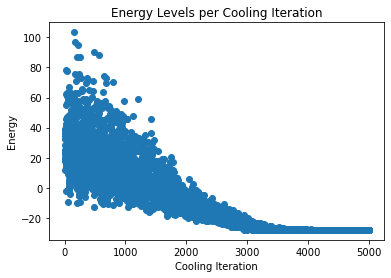

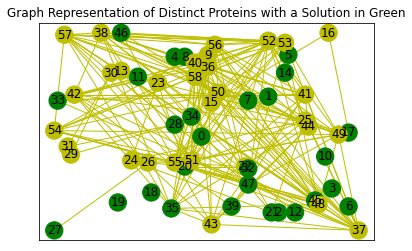

In [9]:
plt.figure()
plt.scatter(np.arange(len(energy_history)), energy_history)
plt.title('Energy Levels per Cooling Iteration')
plt.xlabel('Cooling Iteration')
plt.ylabel('Energy')
generate_node_graph('Graph Representation of Distinct Proteins with a Solution in Green', solution_history[len(solution_history) - 1])


Show our solution set:

In [16]:
non_redundant_proteins = proteins[udmis.occupations]
print(f'Found {len(non_redundant_proteins)} non redundant proteins:')
print(non_redundant_proteins)

Found 28 non redundant proteins:
['1bksA' '3f2bA' '2yb1A' '3e38A' '2anuA' '3qy6A' '1v77A' '3dcpA' '3au2A'
 '2a3lA' '2qpxA' '3iacA' '1itqA' '2ffiA' '3irsA' '3cjpA' '4dziC' '2gwgA'
 '2y1hB' '2vc5A' '1a4mA' '2ogjA' '1a5kC' '1yrrB' '3pnuA' '2imrA' '3ooqA'
 '3icjA']


Now we can try and solve this same system on dwave

In [10]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from minorminer import find_embedding
import networkx as nx
import dwave.inspector

In [11]:
Q = np.zeros([udmis.num_vertices, udmis.num_vertices])
Q[edges == True] = 1
np.fill_diagonal(Q, -1)

linear={(k, k):Q[k][k] for k in range(udmis.num_vertices)}
quadratic={(i, j):Q[i][j] for i in range(udmis.num_vertices) for j in range(udmis.num_vertices) if Q[i,j]>0 and j<i+1}

QDwave = dict(linear)
QDwave.update(quadratic)

chainstrength = 2
numruns = 100
sampler = EmbeddingComposite(DWaveSampler())


response = sampler.sample_qubo(QDwave, chain_strength=chainstrength, num_reads=numruns)
print(response)
dwave.inspector.show(QDwave,response)

    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 58 energy num_oc. ...
0   1  1  1  1  1  1  1  1  1  0  1  1  1  0  1  1  0 ...  0  -28.0       1 ...
1   1  1  1  1  1  1  1  1  0  1  1  1  1  0  1  0  0 ...  0  -28.0       1 ...
2   1  1  1  1  1  1  1  1  0  1  1  1  1  0  1  0  1 ...  0  -27.0       1 ...
3   1  1  1  1  1  1  1  1  0  1  1  1  1  0  1  0  1 ...  0  -27.0       1 ...
4   1  1  1  1  1  1  1  1  0  1  1  1  1  0  1  0  1 ...  0  -27.0       1 ...
5   1  1  1  1  1  1  1  1  0  0  1  1  1  0  1  1  0 ...  0  -27.0       1 ...
6   1  1  1  1  1  1  1  1  0  1  1  1  1  0  1  0  1 ...  0  -27.0       1 ...
7   1  1  1  1  1  1  1  1  0  1  1  1  1  0  1  1  0 ...  0  -27.0       1 ...
8   1  1  1  1  1  1  1  1  0  1  1  1  1  0  1  0  0 ...  0  -27.0       1 ...
9   1  1  1  1  1  1  1  1  0  1  1  1  1  0  1  0  0 ...  0  -27.0       1 ...
10  1  1  1  1  1  1  1  1  1  0  1  1  1  0  0  0  0 ...  0  -27.0       1 ...
11  1  1  1  1  1  1  1  1  0  1  1  1  

'http://127.0.0.1:18000/?problemId=208b0f62-7cca-499c-ad8e-e80a333a32f7'

We show the images extracted from Dwave at http://127.0.0.1:18000/?problemId=208b0f62-7cca-499c-ad8e-e80a333a32f7

Here is the graph representation of the problem and solution on dwave (zoomed in and missing peripheral nodes)

![Dwave Protein Graph Representation](./resources/protein-graph-representation-on-dwave.png)

Here is the embedding on Dwave 2000Q (zoomed in)

![Dwave Protein Embeddings](./resources/protein-zoomed-in-embeddings-on-dwave.png)

A snipped of the energies sampled by Dwave

![Dwave Protein Energeis](./resources/protein-energies.png)